# letters: 0-255, spacer:256, blank(e):257

In [1]:
BLANK_VAL = 257

#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func2 import *


c:\Users\nntin\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
c:\Users\nntin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
dna_vocab = [f"_{x}_" for x in range(256)]#.append(['spacer','blank'])
dna_vocab.append('spacer')
dna_vocab.append('blank')
# dna_vocab.append('_')
print(dna_vocab)
print(dna_vocab[255])

['_0_', '_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_', '_8_', '_9_', '_10_', '_11_', '_12_', '_13_', '_14_', '_15_', '_16_', '_17_', '_18_', '_19_', '_20_', '_21_', '_22_', '_23_', '_24_', '_25_', '_26_', '_27_', '_28_', '_29_', '_30_', '_31_', '_32_', '_33_', '_34_', '_35_', '_36_', '_37_', '_38_', '_39_', '_40_', '_41_', '_42_', '_43_', '_44_', '_45_', '_46_', '_47_', '_48_', '_49_', '_50_', '_51_', '_52_', '_53_', '_54_', '_55_', '_56_', '_57_', '_58_', '_59_', '_60_', '_61_', '_62_', '_63_', '_64_', '_65_', '_66_', '_67_', '_68_', '_69_', '_70_', '_71_', '_72_', '_73_', '_74_', '_75_', '_76_', '_77_', '_78_', '_79_', '_80_', '_81_', '_82_', '_83_', '_84_', '_85_', '_86_', '_87_', '_88_', '_89_', '_90_', '_91_', '_92_', '_93_', '_94_', '_95_', '_96_', '_97_', '_98_', '_99_', '_100_', '_101_', '_102_', '_103_', '_104_', '_105_', '_106_', '_107_', '_108_', '_109_', '_110_', '_111_', '_112_', '_113_', '_114_', '_115_', '_116_', '_117_', '_118_', '_119_', '_120_', '_121_', '_122_', '_

In [3]:
#! 

class DNA_vocab:
    # character and index is the same for this task    
    def __init__(self, dna_vocab):
        self.dna_vocab = dna_vocab
    def vocab(self):
        return dna_vocab
    def id_to_subword(self,id):
        return dna_vocab[id]

In [4]:
class AudioUnsqueeze:
    def __call__(self, data):
        data['audio'] = data['audio'].unsqueeze(1)
        return data

In [5]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
data_file_name = "out_csv/lsl_10k.csv"

samples_per_sequence = 3

c:\Users\nntin\uni\fyp\fyp2023


In [6]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence, False, False, 1)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

100%|██████████| 10000/10000 [00:05<00:00, 1886.86it/s]

Generated 30000 signals and 30000 labels in 5.703000000008615


Letters: [82] 
barcodes: [] 
ctc_labels: [256, 82, 256]
30000
[163, 163, 171, 193, 130, 201, 221, 141, 170, 189, 156, 225, 241, 181, 191, 137, 166, 163, 185, 171, 111, 135, 173, 212, 179, 196, 145, 115, 228, 148, 152, 162, 133, 185, 174, 202, 184, 179, 120, 263, 147, 180, 128, 166, 124, 125, 125, 201, 129, 182, 138, 132, 161, 138, 184, 167, 168, 162, 122, 139, 156, 167, 170, 259, 133, 98, 181, 185, 153, 195, 137, 149, 186, 164, 120, 126, 163, 178, 139, 114, 140, 142, 220, 205, 177, 208, 184, 212, 192, 218, 119, 166, 242, 166, 121, 135, 182, 163, 167, 170, 197, 181, 191, 184, 202, 163, 218, 127, 138, 161, 210, 178, 206, 178, 180, 161, 185, 144, 152, 152, 157, 139, 155, 202, 127, 126, 193, 199, 213, 163, 180, 164, 166, 156, 204, 156, 114, 149, 136, 174, 149, 163, 176, 122, 159, 161, 176, 148, 219, 185, 155, 142, 133, 211, 100, 121, 153, 147, 169, 166, 199, 197, 162, 149, 211, 151, 153, 208, 139, 157, 156, 161, 144, 152, 159, 209, 200, 269, 182, 92, 215, 185, 166, 187, 168, 149, 189, 155,

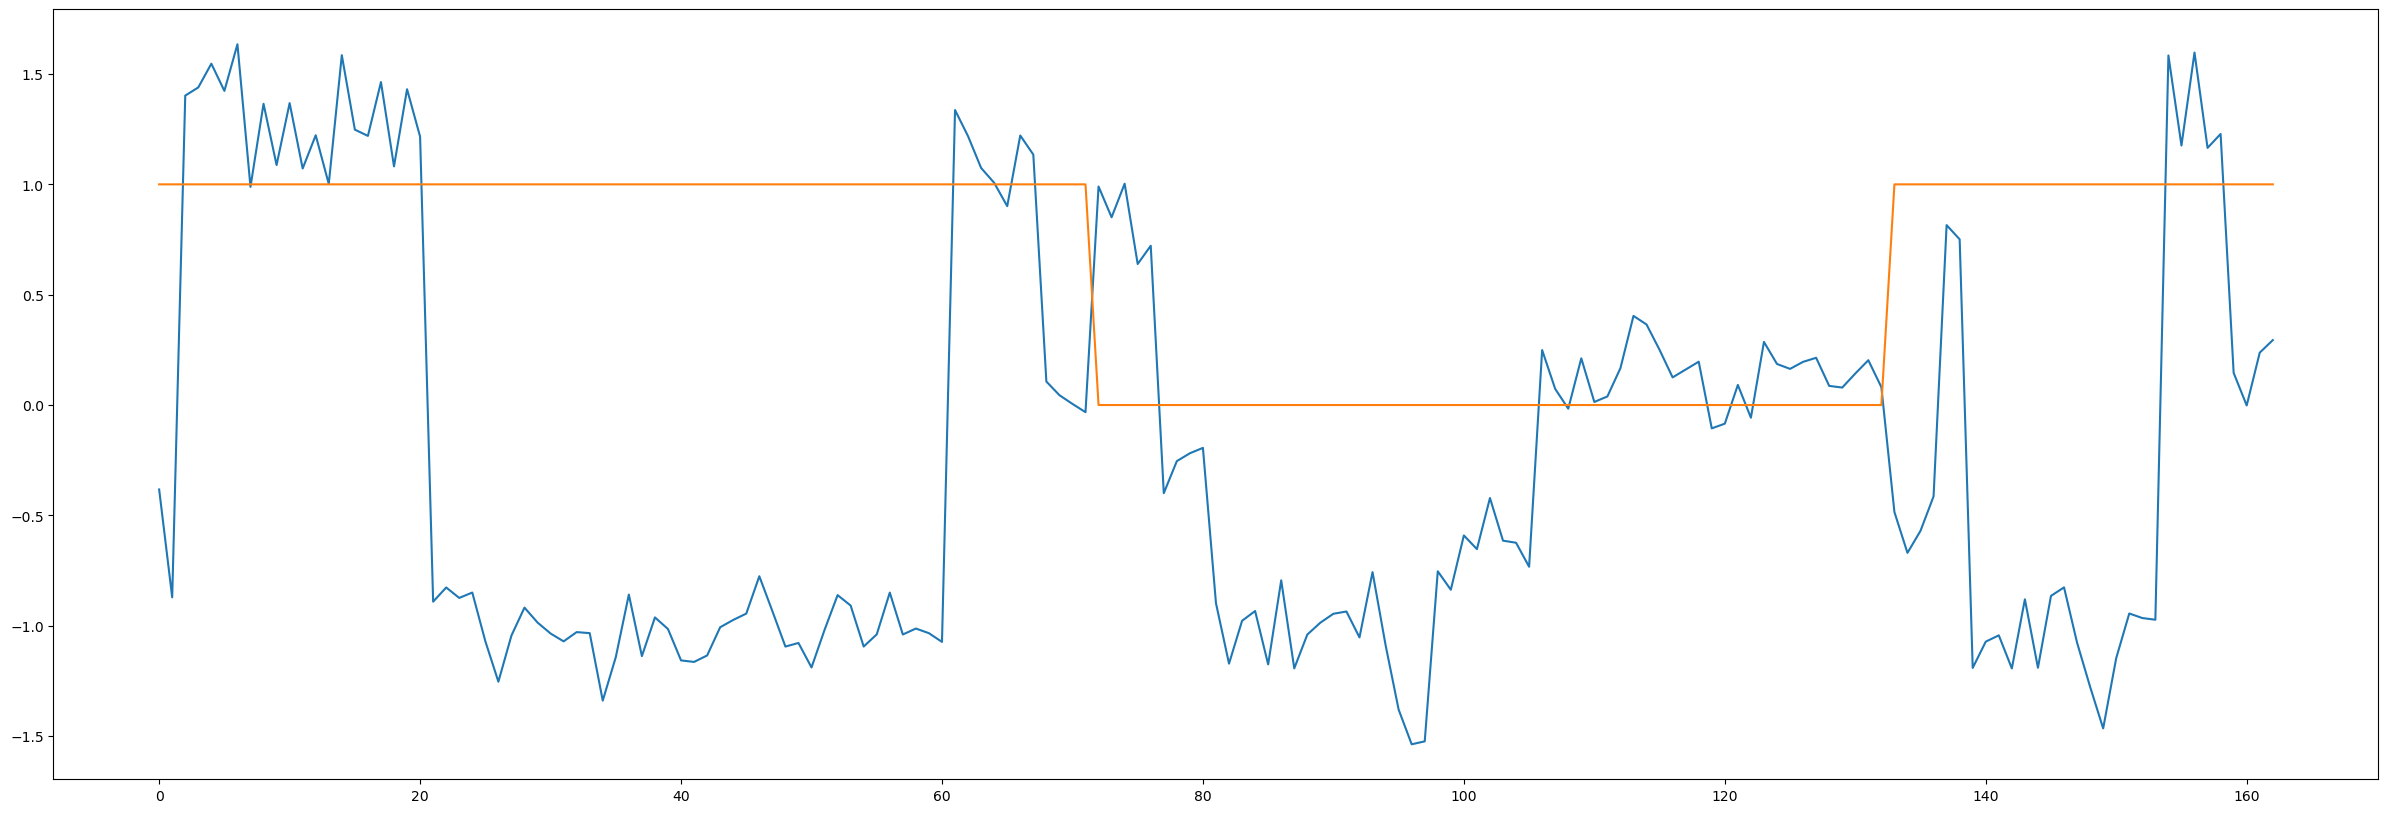

In [7]:
plt.figure(figsize=(30, 10))
i  = 0
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

print(len(signals))
# print(len(signals[i]))
print(([len(x) for x in signals]))
print(max([len(x) for x in signals]))

In [8]:
print(len(signals[i]),len(spacer_labels[i]))

163 163


In [9]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[index]), 'text': np.array(self.y_data[index]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [10]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [11]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'DNA_FYP_2023', 'log_interval': 20},
 'model': {'name': '_quartznet5x5_config', 'vocab_size': 258, 'feat_in': 1}}

In [12]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)
bpe = DNA_vocab(dna_vocab)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    AudioUnsqueeze() #! Tin add
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get(
    #         'sample_rate', 16000),  # for LJspeech
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad(), # pad both audio and text
    AudioUnsqueeze() #! Tin add
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
# val_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)
val_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

# print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
).float()
# model = QuartzNet(
#     model_config=getattr(
#         quartznet_configs, config.model.name, '_quartznet5x5_config'),**config)


# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

#! load model

f = []
mypath = 'checkpoints_free'
for (dirpath, dirnames, filenames) in os.walk(mypath):
    f.extend(filenames)

best_model_epoch = [int(x.split('_')[1]) for x in f]
# print(best_model_epoch)
best_model_name = mypath + '/' + f[best_model_epoch.index(max(best_model_epoch))]

if config.train.get('from_checkpoint', None) is not None:
    defined_model_name = mypath + '/' + config.train.from_checkpoint
    model.load_weights(defined_model_name)
    print(f'load from checkpoint {defined_model_name}')
else:
    model.load_weights(best_model_name) # best by epoch
    print(f'load from checkpoint {best_model_name}')

#! !!!!!!!

if torch.cuda.is_available():
    model = model.cuda()


criterion = nn.CTCLoss(blank=BLANK_VAL, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)

#!!!
decoder = GreedyDecoder(bpe=bpe,blank_index=BLANK_VAL,space_simbol='spacer')
# decoder = BeamCTCDecoder(bpe=bpe,blank_index=BLANK_VAL)


prev_wer = 1000
#! TIN CHNAGE
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

<All keys matched successfully>
load from checkpoint checkpoints_free/model_41_0.9333333333333335.pth


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nguyennhuttin (monash-deep-neuron). Use `wandb login --relogin` to force relogin


[]

In [13]:
bpe.vocab()

['_0_',
 '_1_',
 '_2_',
 '_3_',
 '_4_',
 '_5_',
 '_6_',
 '_7_',
 '_8_',
 '_9_',
 '_10_',
 '_11_',
 '_12_',
 '_13_',
 '_14_',
 '_15_',
 '_16_',
 '_17_',
 '_18_',
 '_19_',
 '_20_',
 '_21_',
 '_22_',
 '_23_',
 '_24_',
 '_25_',
 '_26_',
 '_27_',
 '_28_',
 '_29_',
 '_30_',
 '_31_',
 '_32_',
 '_33_',
 '_34_',
 '_35_',
 '_36_',
 '_37_',
 '_38_',
 '_39_',
 '_40_',
 '_41_',
 '_42_',
 '_43_',
 '_44_',
 '_45_',
 '_46_',
 '_47_',
 '_48_',
 '_49_',
 '_50_',
 '_51_',
 '_52_',
 '_53_',
 '_54_',
 '_55_',
 '_56_',
 '_57_',
 '_58_',
 '_59_',
 '_60_',
 '_61_',
 '_62_',
 '_63_',
 '_64_',
 '_65_',
 '_66_',
 '_67_',
 '_68_',
 '_69_',
 '_70_',
 '_71_',
 '_72_',
 '_73_',
 '_74_',
 '_75_',
 '_76_',
 '_77_',
 '_78_',
 '_79_',
 '_80_',
 '_81_',
 '_82_',
 '_83_',
 '_84_',
 '_85_',
 '_86_',
 '_87_',
 '_88_',
 '_89_',
 '_90_',
 '_91_',
 '_92_',
 '_93_',
 '_94_',
 '_95_',
 '_96_',
 '_97_',
 '_98_',
 '_99_',
 '_100_',
 '_101_',
 '_102_',
 '_103_',
 '_104_',
 '_105_',
 '_106_',
 '_107_',
 '_108_',
 '_109_',
 '_110_',


In [14]:
print(bpe.vocab())
# bpe.vocab().index('_')
int_to_char = bpe.id_to_subword
int_to_char(257)

['_0_', '_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_', '_8_', '_9_', '_10_', '_11_', '_12_', '_13_', '_14_', '_15_', '_16_', '_17_', '_18_', '_19_', '_20_', '_21_', '_22_', '_23_', '_24_', '_25_', '_26_', '_27_', '_28_', '_29_', '_30_', '_31_', '_32_', '_33_', '_34_', '_35_', '_36_', '_37_', '_38_', '_39_', '_40_', '_41_', '_42_', '_43_', '_44_', '_45_', '_46_', '_47_', '_48_', '_49_', '_50_', '_51_', '_52_', '_53_', '_54_', '_55_', '_56_', '_57_', '_58_', '_59_', '_60_', '_61_', '_62_', '_63_', '_64_', '_65_', '_66_', '_67_', '_68_', '_69_', '_70_', '_71_', '_72_', '_73_', '_74_', '_75_', '_76_', '_77_', '_78_', '_79_', '_80_', '_81_', '_82_', '_83_', '_84_', '_85_', '_86_', '_87_', '_88_', '_89_', '_90_', '_91_', '_92_', '_93_', '_94_', '_95_', '_96_', '_97_', '_98_', '_99_', '_100_', '_101_', '_102_', '_103_', '_104_', '_105_', '_106_', '_107_', '_108_', '_109_', '_110_', '_111_', '_112_', '_113_', '_114_', '_115_', '_116_', '_117_', '_118_', '_119_', '_120_', '_121_', '_122_', '_

'blank'

In [15]:
b=train_dataset.__getitem__(2)
b['audio'].shape

(171,)

In [16]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print((b['input_lengths']))
print((b['target_lengths']))
print(b['text'].shape)

print(b['audio'].dtype)
print(b['text'].dtype)


3
8
8
163
5
8
8
torch.Size([8, 1, 221])
tensor([163, 163, 171, 193, 130, 201, 221, 141], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
torch.Size([8, 3])
torch.float64
torch.int32


In [17]:
print(b.keys())

dict_keys(['audio', 'text', 'sample_rate', 'input_lengths', 'target_lengths'])


In [18]:

for epoch_idx in tqdm(range(config.train.get('epochs', 10))):
    # train:
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        batch1=batch
        # print(len(batch1['audio'][0]))
        batch = batch_transforms_train(batch)
        batch2=batch
        # print(len(batch2['audio'][0]))

        optimizer.zero_grad()
        logits = model(batch['audio'].float())
        
        output_length = torch.ceil(
            batch['input_lengths'].float() / model.stride).int()
        
        # print('batch audio shape:', batch['audio'].shape, batch['audio'].dtype )
        # print('logits shape:', logits.shape)
        # print('output_length shape:',output_length)
        # print('target_lengths:',batch['target_lengths'])
        
        loss = criterion(logits.permute(2, 0, 1).log_softmax(
            dim=2), batch['text'], output_length, batch['target_lengths']) # target_length is the length of text of batch1 (before batch aug)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config.train.get('clip_grad_norm', 15))
        optimizer.step()
        lr_scheduler.step()
        # warmup_scheduler.dampen()
        # break
        if batch_idx % config.wandb.get('log_interval', 5000) == 0:
            target_strings = decoder.convert_to_strings(batch['text'])
            decoded_output = decoder.decode(
                logits.permute(0, 2, 1).softmax(dim=2))
            # print(target_strings)
            # print(decoded_output)

            wer = np.mean([decoder.wer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            cer = np.mean([decoder.cer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            step = epoch_idx * \
                len(train_dataloader) * train_dataloader.batch_size + \
                batch_idx * train_dataloader.batch_size
            #! TIN change
            wandb.log({
                "train_loss": loss.item(),
                "train_wer": wer,
                "train_cer": cer,
                "train_samples": wandb.Table(
                    columns=['gt_text', 'pred_text'],
                    data=list(zip(target_strings, decoded_output))
                )
            }, step=step)
        # print(decoded_output)
    # #!
    # validate:
    model.eval()
    val_stats = defaultdict(list)
    for batch_idx, batch in enumerate(val_dataloader):
        batch = batch_transforms_val(batch)
        with torch.no_grad():
            logits = model(batch['audio'].float())
            output_length = torch.ceil(
                batch['input_lengths'].float() / model.stride).int()
            loss = criterion(logits.permute(2, 0, 1).log_softmax(
                dim=2), batch['text'], output_length, batch['target_lengths'])

        target_strings = decoder.convert_to_strings(batch['text'])
        decoded_output = decoder.decode(
            logits.permute(0, 2, 1).softmax(dim=2))
        wer = np.mean([decoder.wer(true, pred)
                        for true, pred in zip(target_strings, decoded_output)])
        cer = np.mean([decoder.cer(true, pred)
                        for true, pred in zip(target_strings, decoded_output)])
        val_stats['val_loss'].append(loss.item())
        val_stats['wer'].append(wer)
        val_stats['cer'].append(cer)
    for k, v in val_stats.items():
        val_stats[k] = np.mean(v)
    val_stats['val_samples'] = wandb.Table(
        columns=['gt_text', 'pred_text'], data=list(zip(target_strings, decoded_output)))
    wandb.log(val_stats, step=step)

    # save model, TODO: save optimizer:
    if val_stats['wer'] < prev_wer:
        os.makedirs(config.train.get(
            'checkpoint_path', 'checkpoints'), exist_ok=True)
        prev_wer = val_stats['wer']
        torch.save(
            model.state_dict(),
            os.path.join(config.train.get(
                'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth')
        )
        # wandb.save(os.path.join(config.train.get(
        #     'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth'))
    break

  0%|          | 0/42 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
s1=target_strings[0]
s2=decoded_output[0]
b = set(s1.split('spacer') + s2.split('spacer'))
b = set(s1.split('spacer') + s2.split('spacer'))
print(b)
word2char = dict(zip(b, range(len(b))))
print(word2char)

# map the words to a char array (Levenshtein packages only accepts
# strings)
w1 = [(word2char[w]) for w in s1.split('spacer')]
print(s1)
print(w1)
w2 = [(word2char[w]) for w in s2.split('spacer')]
print(s2)
print(w2)
# return Lev.distance(''.join(w1), ''.join(w2)) / len(w1)

s1_concated, s2_concated = s1.replace(
            'spacer', ''), s2.replace('spacer', '')

print(s1_concated)
print(s2_concated)

{'', '_25_'}
{'': 0, '_25_': 1}
spacer_25_spacer
[0, 1, 0]
spacer
[0, 0]
_25_



In [ ]:
target_strings

['spacer_25_spacer']

In [ ]:
decoded_output

['spacer']

In [ ]:
logits.permute(2, 0, 1).log_softmax(
            dim=2).shape

torch.Size([77, 1, 258])

In [ ]:
batch2.keys()

dict_keys(['audio', 'text', 'sample_rate', 'input_lengths', 'target_lengths'])

In [ ]:
batch2['input_lengths']

tensor([153], device='cuda:0')

In [ ]:
print(len(batch1['audio'])) # batchsize
print(len(batch1['audio'][0]))
print(len(batch2['audio'][0]))
print(max([len(x) for x in batch1['audio'] ]))

1
153
1
153


In [ ]:
from torchaudio.models.decoder import ctc_decoder

In [ ]:
decoder = ctc_decoder(None,tokens=bpe.vocab(),blank_token='blank',sil_token='spacer')

In [ ]:
a=logits.permute(0, 2, 1).softmax(dim=2)
print(a.shape)
results = decoder(a.cpu())
print(results)

print(a[0,2].argmax())

torch.Size([1, 77, 258])
[[CTCHypothesis(tokens=tensor([256]), words=[], score=76.99207842350006, timesteps=tensor([0], dtype=torch.int32))]]
tensor(256, device='cuda:0')
